In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

### Загрузим данные

In [61]:
df = pd.read_csv('Sample.csv')
df.head()

,ID_check,ID_store,Date_buy,ID_SKU,SKU_QTY,SKU_cost,Discount
0,696320,1,2019-06-29,1,2,92.98,0.0
1,765510,1,2019-07-22,1,2,75.98,0.0
2,545988,1,2019-05-17,1,4,151.96,0.0
3,652136,1,2019-06-17,1,2,75.98,0.0
4,803674,1,2019-08-04,1,4,181.96,0.0


In [300]:
df.shape

(3218829, 8)

### Подготовим данные

In [62]:
df.Date_buy = pd.to_datetime(df.Date_buy)

In [63]:
df = df.sort_values('Date_buy')

Переобозначим столбцы ID_store и ID_SKU, для удобства работы с ними

In [64]:
from sklearn import preprocessing


store_le = preprocessing.LabelEncoder()
store_le.fit(df['ID_store'].unique())
df['ID_store'] = store_le.transform(df['ID_store'])

product_le = preprocessing.LabelEncoder()
product_le.fit(df['ID_SKU'].unique())
df['ID_SKU'] = product_le.transform(df['ID_SKU'])

In [65]:
df.head()

,ID_check,ID_store,Date_buy,ID_SKU,SKU_QTY,SKU_cost,Discount
1126291,155189,198,2019-01-01,1,2,139.80,0.0
1307958,155132,257,2019-01-01,1,2,139.80,0.0
1988063,2312723,1617,2019-01-01,1,1,71.90,0.0
815118,154141,1015,2019-01-01,0,1,37.99,0.0
2164371,155082,1842,2019-01-01,1,2,139.80,0.0


Представим некоторые данные из таблицы на графике, чтобы иметь более четкое понимание как выглядят данные.

<Figure size 1440x1440 with 0 Axes>

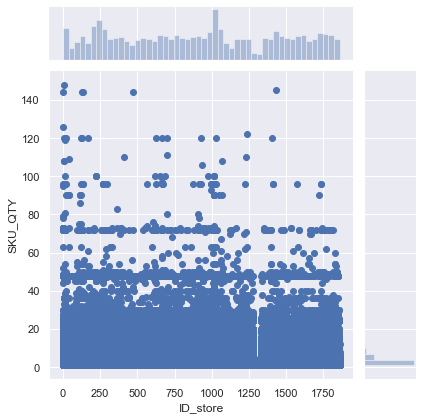

In [284]:
plt.figure(figsize=(20, 20))
#plt.plot(df[df.ID_SKU == 951398].Date_buy, df[df.ID_SKU == 951398].SKU_QTY)
sns.jointplot(x='ID_store', y='SKU_QTY', data=df)

Избавимся от выбросов.

In [301]:
df = df[df.SKU_QTY < 150]

### Preprocessing

Создадим матрицу с каждой комбинацией недели, магазина и вещи.

In [302]:
df['date_block_num'] = df['Date_buy'].dt.week
df.loc[(df.Date_buy >= '2020-01-01') & (df.date_block_num == 1), 'date_block_num'] = 53
df.loc[(df.Date_buy >= '2020-01-01') & (df.date_block_num == 2), 'date_block_num'] = 54

In [303]:
from itertools import product

grid = []  
cols = ['date_block_num', 'ID_store', 'ID_SKU']

for i in range(1, 55):
    sales = df[df.date_block_num == i]
    grid.append(np.array(list(product([i], sales.ID_store.unique(), sales.ID_SKU.unique() ) ), dtype=np.int16))

grid = pd.DataFrame(np.vstack(grid), columns = cols)
grid.sort_values(cols, inplace=True)

Добавим суммарные продажи за неделю для конкретного магазина и конкретного товара. И средние продажи за нделю для конкретного товара без учета магазина. 

In [304]:
group = df.groupby(['date_block_num', 'ID_store', 'ID_SKU']).agg({'SKU_QTY' : 'sum'})
group.columns = ['store_item_cnt_sum']
group.reset_index(inplace=True)

grid = grid.merge(group, on = ['date_block_num', 'ID_store', 'ID_SKU'], how='left')
grid.store_item_cnt_sum.fillna(0, inplace=True)

In [305]:
group = df.groupby(['date_block_num', 'ID_SKU']).agg({'SKU_QTY' : 'mean'})
group.columns = ['item_cnt_mean']
group.reset_index(inplace=True)

grid = grid.merge(group, on = ['date_block_num', 'ID_SKU'], how='left')
grid.item_cnt_mean.fillna(0, inplace=True)

### Idea 0: Добавим столбец *itemshop_cnt_week_lag_i*. В нем находятся суммарные продажи для конкретного магазина и продукта за прошлые недели

In [306]:
def lag_feature(df, lags, col):
    shifted = df[["date_block_num", "ID_store","ID_SKU",col]].copy()
    for i in lags:
        shifted.columns = ["date_block_num", "ID_store", "ID_SKU", col + "_lag_"+str(i)]
        shifted.date_block_num += i
        df = pd.merge(df, shifted, on=['date_block_num','ID_store','ID_SKU'], how='left')
        df[col + "_lag_"+str(i)] = df[col + "_lag_"+str(i)].fillna(0)       
    return df

In [307]:
grid = lag_feature(grid, [1, 2, 3, 4, 5, 6], 'store_item_cnt_sum')

### Idea 1: Добавим столбец item_cnt_week_lag_i. В нем находятся средние продажи для конкретного продукта без учета магазина за прошлые недели

In [308]:
grid = lag_feature(grid, [1, 2, 3, 4, 5, 6], 'item_cnt_mean')

### Idea 2: Добавим столбец цена за прошлые недели. 

In [309]:
group = df.groupby(['date_block_num', 'ID_SKU']).agg({'SKU_cost': 'mean'})
group.columns = ['item_price_mean'] 
group.reset_index(inplace = True)
grid = grid.merge(group, on = ['date_block_num', 'ID_SKU'], how = 'left')

In [310]:
grid = lag_feature(grid, [1, 2, 3, 4, 5, 6], 'item_price_mean')

### Idea 3: Добавим столбец со скидкой 

In [311]:
group = df.groupby(['date_block_num', 'ID_store', 'ID_SKU']).agg({'Discount': 'max'})
group.columns = ['discount_max'] 
group.reset_index(inplace = True)
grid = grid.merge(group, on = ['date_block_num', 'ID_store', 'ID_SKU'], how = 'left')

In [312]:
grid = lag_feature(grid, [1, 2, 3], 'discount_max')

In [313]:
grid

,date_block_num,ID_store,ID_SKU,store_item_cnt_sum,item_cnt_mean,store_item_cnt_sum_lag_1,store_item_cnt_sum_lag_2,store_item_cnt_sum_lag_3,store_item_cnt_sum_lag_4,store_item_cnt_sum_lag_5,...,item_price_mean_lag_1,item_price_mean_lag_2,item_price_mean_lag_3,item_price_mean_lag_4,item_price_mean_lag_5,item_price_mean_lag_6,discount_max,discount_max_lag_1,discount_max_lag_2,discount_max_lag_3
0,1,0,0,4.0,3.819456,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,0,1,87.0,2.349227,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,1,0,2,31.0,3.420690,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,1,1,0,71.0,3.819456,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,1,1,1,38.0,2.349227,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283504,54,1858,1,17.0,2.214512,30.0,40.0,51.0,33.0,41.0,...,168.250911,150.294717,145.595193,147.472243,159.807694,162.670353,0.0,0.0,0.0,0.0
283505,54,1858,2,0.0,3.032406,44.0,55.0,24.0,98.0,18.0,...,104.727690,83.723401,82.866276,88.338505,88.454667,95.984257,NaN,0.0,0.0,0.0
283506,54,1859,0,11.0,3.374438,27.0,0.0,0.0,0.0,0.0,...,178.623997,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
283507,54,1859,1,25.0,2.214512,22.0,0.0,0.0,0.0,0.0,...,168.250911,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### Idea 3: Добавим номер недели

In [314]:
grid['week_num'] = grid['date_block_num'] % 52

Удалим ненужнын столбцы

In [318]:
grid.drop(['item_cnt_mean', 'item_price_mean'],axis =1, inplace=True)

<Figure size 1440x1440 with 0 Axes>

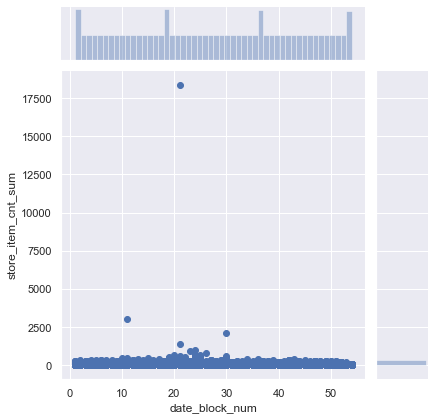

In [319]:
plt.figure(figsize=(20, 20))

sns.jointplot(x='date_block_num', y='store_item_cnt_sum', data=grid) 

Из графика видно, что практически все значения проданных товаров за неделю меньше 1000. 

### Modeling

Разобьем данные на test и train согласно заданию в test выборку попадут данные за последние 10 недель

In [320]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm

In [321]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

In [322]:
def mape(y_pred, y_true):
    return  abs(1 - np.sum(abs(y_pred - y_true)) / np.sum(y_true))

In [323]:
grid.columns

Index(['date_block_num', 'ID_store', 'ID_SKU', 'store_item_cnt_sum',
       'store_item_cnt_sum_lag_1', 'store_item_cnt_sum_lag_2',
       'store_item_cnt_sum_lag_3', 'store_item_cnt_sum_lag_4',
       'store_item_cnt_sum_lag_5', 'store_item_cnt_sum_lag_6',
       'item_cnt_mean_lag_1', 'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3',
       'item_cnt_mean_lag_4', 'item_cnt_mean_lag_5', 'item_cnt_mean_lag_6',
       'item_price_mean_lag_1', 'item_price_mean_lag_2',
       'item_price_mean_lag_3', 'item_price_mean_lag_4',
       'item_price_mean_lag_5', 'item_price_mean_lag_6', 'discount_max',
       'discount_max_lag_1', 'discount_max_lag_2', 'discount_max_lag_3',
       'week_num'],
      dtype='object')

In [453]:
def train_and_predict(model, data):
    features = ['date_block_num' , 'ID_store', 'ID_SKU', 'store_item_cnt_sum_lag_1']
    features += ['store_item_cnt_sum_lag_2', 'store_item_cnt_sum_lag_3']
    features += ['store_item_cnt_sum_lag_4', 'store_item_cnt_sum_lag_5']
#     features += ['store_item_cnt_sum_lag_6']
    features += ['item_price_mean_lag_1', 'item_price_mean_lag_2', 'discount_max']
    
    X_train = data[(data.date_block_num < 45)][features]
    y_train = data[(data.date_block_num < 45)]['store_item_cnt_sum']
    
    X_test = data[data.date_block_num >= 45][features]
    y_test = data[data.date_block_num >= 45]['store_item_cnt_sum']
    
    model.fit(X_train, y_train) 
    
    y = model.predict(X_test)
    return y, y_test

In [426]:
grid.fillna(0, inplace=True)

Начнем с линейной модели

In [427]:
y_pred, y_test = train_and_predict(lm.BayesianRidge(), grid)

In [428]:
#  features = ['date_block_num' , 'ID_store', 'ID_SKU', 'store_item_cnt_sum_lag_1']
#     features += ['store_item_cnt_sum_lag_2', 'store_item_cnt_sum_lag_3']
#     features += ['store_item_cnt_sum_lag_4', 'store_item_cnt_sum_lag_5']
#     #features += ['store_item_cnt_sum_lag_6']
#     features += ['item_price_mean_lag_1', 'item_price_mean_lag_2', 'discount_max'] 335

# features = ['date_block_num' , 'ID_store', 'ID_SKU', 'store_item_cnt_sum_lag_1']
#     features += ['store_item_cnt_sum_lag_2', 'store_item_cnt_sum_lag_3']
#     features += ['store_item_cnt_sum_lag_4', 'store_item_cnt_sum_lag_5']
#     #features += ['store_item_cnt_sum_lag_6']
#     features += ['item_price_mean_lag_1', 'item_price_mean_lag_2', 'item_price_mean_lag_3']
#     features += ['item_price_mean_lag_4']
#     features += ['discount_max', 'discount_max_lag_1']   334



In [429]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred, y_test) #646.8, 393 336 335 334

334.63006391868254

In [430]:
smape(y_pred, y_test)

74.64005183541678

Постром график реальных значений и того, что предсказала модель.

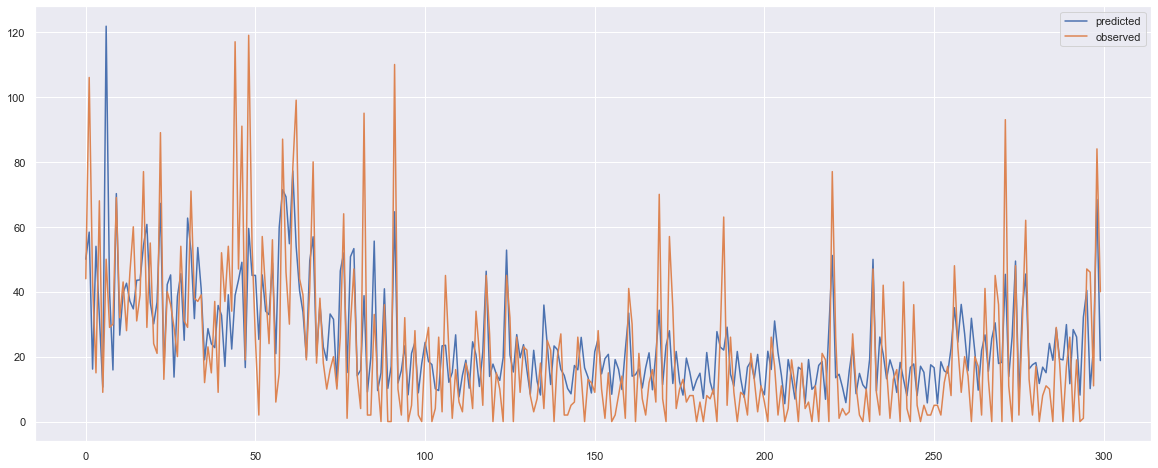

In [373]:
plt.figure(figsize=(20, 8))

plt.plot(list(range(len(y_pred)))[:300], y_pred[:300], label='predicted')
plt.plot(list(range(len(y_test)))[:300], y_test[:300], label='observed')
plt.legend();

Тепреь попробуем более мощный алгоритм 

In [161]:
import xgboost as xgb

In [457]:
y_pred_xgb, y_test_xgb = train_and_predict(xgb.XGBRegressor(
    max_depth=5,
    n_estimators=700,
    min_child_weight=0.3, 
    colsample_bytree=0.8, 
    subsample=1, 
    eta=0.3,
#     tree_method='gpu_hist',
    seed=42,
    nthread = 32), grid)

In [469]:
y_pred_xgb = y_pred_xgb.clip(0, 100)

In [470]:
mean_squared_error(y_pred_xgb, y_test_xgb) #533 527 492

492.18057994914466

In [472]:
error = smape(y_pred_xgb, y_test_xgb)
np.mean(error) #  72,  76 78

79.66619290708057

Построим график реальных значений и того, что предскзала модель

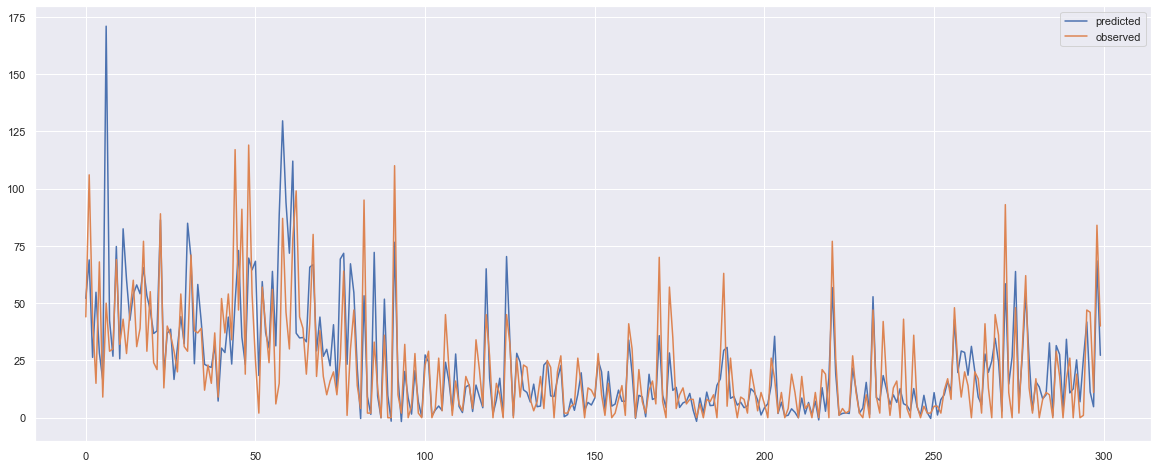

In [460]:
plt.figure(figsize=(20, 8))

plt.plot(list(range(len(y_pred_xgb)))[:300], y_pred_xgb[:300], label='predicted')
plt.plot(list(range(len(y_test_xgb)))[:300], y_test[:300], label='observed')
# plt.plot(list(range(len(y_pred)))[:300], y_pred[:300], label='predicted_lin')
plt.legend();

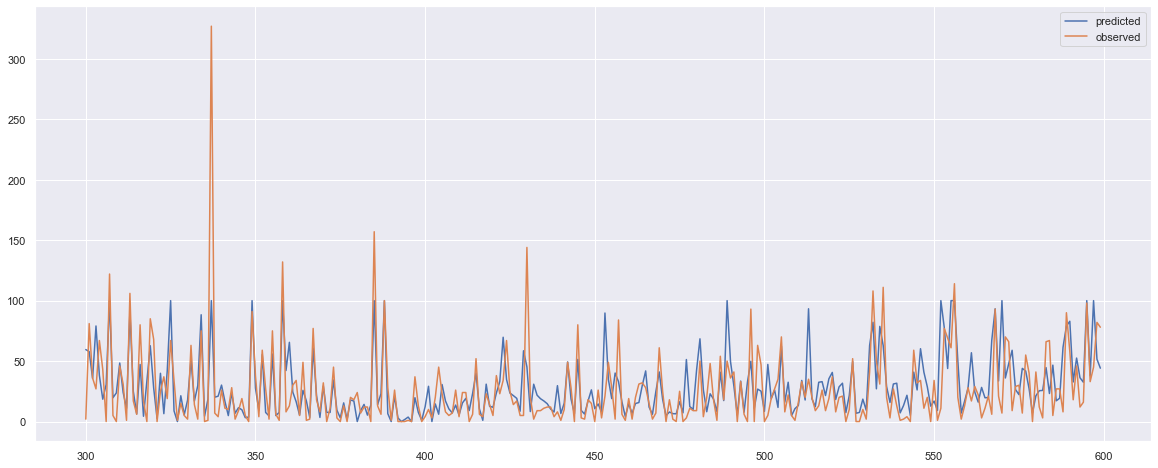

In [473]:
plt.figure(figsize=(20, 8))

plt.plot(list(range(len(y_pred_xgb)))[300:600], y_pred_xgb[300:600], label='predicted')
plt.plot(list(range(len(y_test_xgb)))[300:600], y_test[300:600], label='observed')
# plt.plot(list(range(len(y_pred)))[:300], y_pred[:300], label='predicted_lin')
plt.legend();